Problem set 2

In [1]:
# Import the necessary libraries
import numpy as np
import scipy as sci
import scipy.optimize as opt
import scipy.stats as stats
import pandas as pd
import scipy.integrate as integrate
import matplotlib.pyplot as plt

Question 1

a)

Below we just load the data as a numpy array.

In [2]:
q1_data = np.loadtxt('clms.txt')

Below we show the statistics asked.

In [3]:
print('The mean is: ',np.mean(q1_data))
print('The median is: ',np.median(q1_data))
print('The standard deviation is: ',np.std(q1_data))
print('The minimum is: ',np.min(q1_data))
print('The maximum is: ',np.max(q1_data))

The mean is:  720.2779753272437
The median is:  172.21
The standard deviation is:  3972.663756393663
The minimum is:  0.01
The maximum is:  227967.25


Below we first show the histogram containing all the data and using the same weights for all observations (that is, 1 over the number of observations). As we can see, because the data is pretty much concentrated on the left end (higher values are very unlikely), this plot is not very informative.

We can that the heights in the histogram sum to  1.0000000000000322


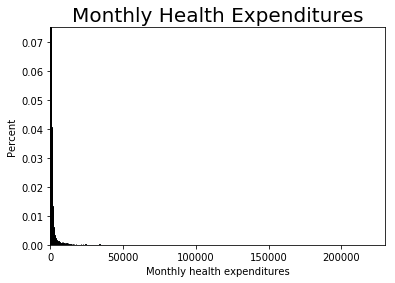

In [4]:
num_bins = 1000
weights = (1/q1_data.shape[0])*np.ones_like(q1_data)
count, bins, ignored = plt.hist(q1_data, num_bins, weights=weights,
                                edgecolor='k')
plt.title('Monthly Health Expenditures', fontsize=20)
plt.xlabel(r'Monthly health expenditures')
plt.ylabel(r'Percent')
plt.xlim([0, 230000])  # This gives the xmin and xmax to be plotted"
plt.ylim([0,0.075])

print('We can that the heights in the histogram sum to ',count.sum())

Below we plot the second histogram asked for. Here we filter the data, to plot the histogram only for the portion where expenditures are below \$ 800,00, but keep the original weights - which result in the sum of the heights being smaller than one. But, as we can see, it is higher than 0.80, since most of the data is in this range. This results in a histogram that contains information much easier to analyze, making it easier to understand the distribution of expenditures in the range where they happen more often. That is why we would prefer this one. 

We can that the heights in the histogram sum to  0.8494208494208465


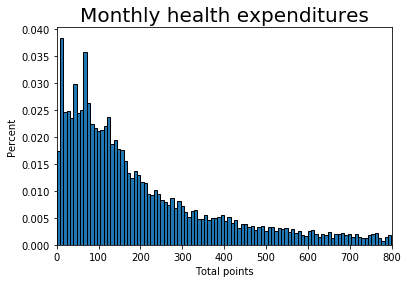

In [5]:
num_bins = 100
weights = (1/q1_data.shape[0])*np.ones_like(q1_data[(q1_data<=800)])
count, bins, ignored = plt.hist(q1_data[(q1_data<=800)], num_bins, weights=weights,
                                edgecolor='k')
plt.title('Monthly health expenditures', fontsize=20)
plt.xlabel(r'Total points')
plt.ylabel(r'Percent')
plt.xlim([0, 800])  # This gives the xmin and xmax to be plotted"

print('We can that the heights in the histogram sum to ',count.sum())

b)

Below I create the criterion function that will be minimized by the optimizer to find the MLE estimates. It takes the mean of the values obtained by passing the data vector and the parameter values as arguments to the built-in log-pdf function of the gamma distribution; and then returns the negative of this mean (since we want to maximize the log-likelihood, but will use a minimizer.

Also, I am passing as arguments the exponential of the trial parameters, to enforce that these parameters be positive, as required by the Gamma distribution.

In [6]:
def crit_b(params,data):
    alpha, beta = np.exp(params)
    log_lik_val = stats.gamma.logpdf(x=data,a=alpha,scale=beta)
    
    neg_log_lik_val = -np.mean(log_lik_val)
    
    return neg_log_lik_val

In [7]:
beta_init = np.log(((np.std(q1_data))**2)/np.mean(q1_data))
alpha_init = np.log(np.mean(q1_data)/beta_init)
params_init = np.array([alpha_init, beta_init])

results_uncstr_b = opt.minimize(crit_b, params_init, args=q1_data, method='Nelder-Mead')
alpha_MLE, beta_MLE = np.exp(results_uncstr_b.x)
print('alpha_MLE=', alpha_MLE, ' beta_MLE=', beta_MLE)
lik_b = -crit_b(np.log([alpha_MLE,beta_MLE]),q1_data)
print('Maximized Log-likelihood is ',lik_b)

alpha_MLE= 0.47251816997014623  beta_MLE= 1524.3783595230886
Maximized Log-likelihood is  -7.319283682746835


We can see above the values of the parameters obtained and the value of the maximized likelihood. Below we show that the optimization was successful.

In [8]:
results_uncstr_b

 final_simplex: (array([[-0.74967908,  7.32934197],
       [-0.74964998,  7.32926202],
       [-0.7497509 ,  7.32932038]]), array([7.31928368, 7.31928368, 7.31928369]))
           fun: 7.319283682746835
       message: 'Optimization terminated successfully.'
          nfev: 92
           nit: 49
        status: 0
       success: True
             x: array([-0.74967908,  7.32934197])

Now we plot the density function on top of the second histogram of letter (a) above and can see that the fit was not good. This might be related to the long upper tail the data has, which the gamma distribution has difficult fitting without making the fit for the regions of lower expenditures worse.

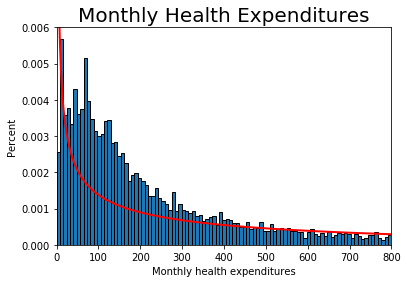

In [9]:
# Plot histogram
def likelihood_b(data,params):
    alpha, beta = params    
    lik_val = stats.gamma.pdf(x=data,a=alpha,scale=beta)    
    return lik_val

num_bins = np.linspace(0.01, 800, 100)
count, bins, ignored = plt.hist(q1_data, num_bins, density=True,
                                edgecolor='k')
plt.title('Monthly Health Expenditures', fontsize=20)
plt.xlabel(r'Monthly health expenditures')
plt.ylabel(r'Percent')
plt.xlim([0, 800])  # This gives the xmin and xmax to be plotted"
plt.ylim([0,0.006])

# Plot smooth line with distribution
dist_pts = np.linspace(0, 800, 700)
alpha = alpha_MLE
beta = beta_MLE
plt.plot(dist_pts, likelihood_b(dist_pts,[alpha,beta]),
         linewidth=2, color='r')

c)

Below we repeat a similar procedure as in (b), but now I constructed the logpdf for generalized gamma instead of using a built-in function. We also use the values for $\alpha$ and $\beta$ obtained in (b) as initial values, as suggested in the question.

In [10]:
def crit_c(params,data):
    alpha, beta, m = np.exp(params)
    log_lik_val = np.log(m)-alpha*np.log(beta)-np.log(sci.special.gamma(alpha/m))+\
        (alpha-1)*np.mean(np.log(data))-(np.mean((data/beta)**m))
    neg_log_lik_val = -log_lik_val    
    return neg_log_lik_val

In [11]:
beta_init = np.log(beta_MLE)
alpha_init = np.log(alpha_MLE)
m_init = np.log(1)
params_init = np.array([alpha_init, beta_init, m_init])

results_uncstr_c = opt.minimize(crit_c, (params_init), args=q1_data, method='Powell')
alpha_MLE_2, beta_MLE_2, m_MLE_2 = np.exp(results_uncstr_c.x)
print('alpha_MLE=', alpha_MLE_2, ' beta_MLE=', beta_MLE_2, ' m_MLE=', m_MLE_2)
lik_c = -crit_c(np.log([alpha_MLE_2,beta_MLE_2,m_MLE_2]),q1_data)
print('Maximized Log-ikelihood is ',lik_c)

alpha_MLE= 2.0282522842572965  beta_MLE= 0.0038838792231951544  m_MLE= 0.20664695781329026
Maximized Log-ikelihood is  -7.068804131222564


The results and maximized likelihood value are displayed above. We can see that, after adding a parameter, the results for $\alpha$ and $\beta$ changed a lot, and the optimization was sucessful. Also, we see below that the fit of histogram was improved a little. The extra parameter appears to be able to at least give the density a hump shape similar to what we see in the histogram.

In [12]:
results_uncstr_c

   direc: array([[ 0.24104181, -0.76727076, -0.03251535],
       [ 0.0572736 , -1.18526324, -0.09796776],
       [ 0.09599968, -1.43525477, -0.0705674 ]])
     fun: 7.068804131222564
 message: 'Optimization terminated successfully.'
    nfev: 667
     nit: 17
  status: 0
 success: True
       x: array([ 0.70717448, -5.55092083, -1.57674346])

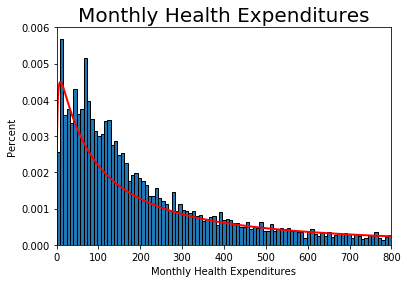

In [13]:
# Plot histogram
def likelihood_c(data,params):
    alpha, beta, m = params    
    log_lik_val = np.log(m)-alpha*np.log(beta)-np.log(sci.special.gamma(alpha/m))+\
        (alpha-1)*(np.log(data))-(((data/beta)**m))
    return np.exp(log_lik_val)

num_bins = np.linspace(0, 800, 100)
count, bins, ignored = plt.hist(q1_data, num_bins, density=True,
                                edgecolor='k')
plt.title('Monthly Health Expenditures', fontsize=20)
plt.xlabel(r'Monthly Health Expenditures')
plt.ylabel(r'Percent')
plt.xlim([0, 800])  # This gives the xmin and xmax to be plotted"
plt.ylim([0,0.006])

# Plot smooth line with distribution 
dist_pts = np.linspace(0.01, 800, 700)
alpha = alpha_MLE_2
beta = beta_MLE_2
m = m_MLE_2

plt.plot(dist_pts, likelihood_c(dist_pts,[alpha,beta,m]),
         linewidth=2, color='r')

d)

Lastly, the procedure above is repeated using the generalized beta of type 2 function to check if we can obtain better results by adding one more parameter.

In [14]:
def crit_d(params,data):
    a, b, p, q = np.exp(params)
    log_lik_val = np.log(a)+(a*p-1)*np.mean(np.log(data))-(a*p)*np.log(b)-np.log(sci.special.beta(p,q))-\
        (p+q)*np.mean(np.log(1+(data/b)**a))
    
    neg_log_lik_val = -log_lik_val
    
    return neg_log_lik_val

In [15]:
q_init = np.log(10000)
b_init = np.log((q_init**(1/m_MLE_2))*beta_MLE_2)
a_init = np.log(m_MLE_2)
p_init = np.log(alpha_MLE_2/m_MLE_2)
params_init = np.array([a_init, b_init, p_init, q_init])

results_uncstr_d = opt.minimize(crit_d, params_init, args=q1_data, method='Nelder-Mead')
a_MLE_3, b_MLE_3, p_MLE_3, q_MLE_3 = np.exp(results_uncstr_d.x)
print('a_MLE=', a_MLE_3, ' b_MLE=', b_MLE_3, ' p_MLE=', p_MLE_3, ' q_MLE=', q_MLE_3)
lik_d = -crit_d(np.log([a_MLE_3,b_MLE_3,p_MLE_3,q_MLE_3]),q1_data)
print('Maximized Log-likelihood is ',lik_d)

a_MLE= 1.2713979504888429  b_MLE= 143.22904140801384  p_MLE= 1.0298598847247653  q_MLE= 0.8484811428278483
Maximized Log-likelihood is  -7.035429576132504


We can see the results above, and below that optimization was sucessful. Also, in the plot below we see that the GB2 does a much better job in fitting the histogram; its "hump" shape now closely follows the shape of the histogram.

In [16]:
results_uncstr_d

 final_simplex: (array([[ 0.24011704,  4.96444504,  0.02942276, -0.16430742],
       [ 0.24006134,  4.9644551 ,  0.02948557, -0.16422635],
       [ 0.24014511,  4.96446082,  0.02939628, -0.16432626],
       [ 0.2401461 ,  4.96450096,  0.02936028, -0.16433376],
       [ 0.24014304,  4.96446647,  0.02937219, -0.16432937]]), array([7.03542958, 7.03542958, 7.03542958, 7.03542958, 7.03542958]))
           fun: 7.035429576132504
       message: 'Optimization terminated successfully.'
          nfev: 575
           nit: 348
        status: 0
       success: True
             x: array([ 0.24011704,  4.96444504,  0.02942276, -0.16430742])

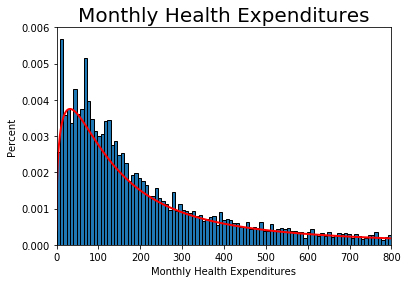

In [17]:
# Plot histogram
def likelihood_d(data,params):
    a, b, p, q = params
    log_lik_val = np.log(a)+(a*p-1)*(np.log(data))-(a*p)*np.log(b)-np.log(sci.special.beta(p,q))-\
        (p+q)*(np.log(1+(data/b)**a))    
    lik_val = np.exp(log_lik_val)    
    return lik_val

num_bins = np.linspace(0, 800, 100)
count, bins, ignored = plt.hist(q1_data, num_bins, density=True,
                                edgecolor='k')
plt.title('Monthly Health Expenditures', fontsize=20)
plt.xlabel(r'Monthly Health Expenditures')
plt.ylabel(r'Percent')
plt.xlim([0, 800])  # This gives the xmin and xmax to be plotted"
plt.ylim([0, 0.006])


# Plot smooth line with distribution
dist_pts = np.linspace(0.01, 800, 700)
a = a_MLE_3
b = b_MLE_3
p = p_MLE_3
q = q_MLE_3
plt.plot(dist_pts, likelihood_d(dist_pts,[a,b,p,q]),
         linewidth=2, color='r')

e)

Below we show the test statistics for the likelihood ratio test statistics. As we can see, the probabilities of getting the data we got under the null of the data being distributed either as Gamma or GG are almost zero, which allows us to reject this hypothesis. And this is consistent with the GB2 providing a much better fit.

In [18]:
#Gamma against GB2
test_stat_1 = q1_data.shape[0]*2*(lik_d-lik_b)
pvalue1 = 1-stats.chi2.cdf(x=test_stat_1,df=4)
#GG against GB2
test_stat_2 = q1_data.shape[0]*2*(lik_d-lik_c)
pvalue2 = 1-stats.chi2.cdf(x=test_stat_2,df=4)

print('The test statistic for testing the Gamma is ',test_stat_1)
print('The p-value for this test statistic is ',pvalue1)
print('The test statistic for testing the GG is ',test_stat_2)
print('The p-value for this test statistic is ',pvalue2)

The test statistic for testing the Gamma is  6028.493516275152
The p-value for this test statistic is  0.0
The test statistic for testing the GG is  708.8088010026834
The p-value for this test statistic is  0.0


f)

Below we show the probabilities of getting 1,000 in monthly expenditures. As we can see, they are not high, as expected, and smaller in the GB2, which had the best fit.

In [19]:
#f
prob1, ignore = integrate.quad(lambda x: likelihood_d(data=x,params=np.array([a_MLE_3,b_MLE_3,p_MLE_3,q_MLE_3])), 0, 1000)
prob1 = 1-prob1
#sci.stats.betaprime.cdf(1000,a=m_MLE_3,b=q_MLE_3,loc=alpha_MLE_3,scale=beta_MLE_3)
print('With GB2, the probability is ',prob1)

prob2 = 1-sci.stats.gamma.cdf(1000,a=alpha_MLE,scale=beta_MLE)
print('With Gamma, the probability is ',prob2)

With GB2, the probability is  0.11766475250934416
With Gamma, the probability is  0.2367836133328448


Question 2

a)

Below we load the data as a panda data frame and: first construct a function to back the value of $z$ from the expression (3) and then construct the criterion function using the log-likelihood of the normal with mean and variance indicated in the question (using a lagged version of $z$ in the mean). 

In [20]:
q2_data = pd.read_csv('MacroSeries.txt', sep=",", header=None, names=["c","k","w","r"])

In [21]:
#Back z
def back_z_a(w,k,alpha):
    z = np.log(w/(((k)**alpha)*(1-alpha)))
    return z
 #Criterion function
def crit_2a(params,q2_data):
    alpha, rho, mu, sigma = params
    z = back_z_a(q2_data['w'],q2_data['k'],alpha)
    z_lag = z.shift(1)
    z_lag[0] = mu
    
    log_lik_val = - np.log(sigma) - 0.5*np.log(2 * np.pi) - (z - (rho*z_lag+(1-rho)*mu))**2 / (2 * sigma**2)
    
    return -np.mean(log_lik_val) 


Below we use the same optimization routine used in question 1, but we provide bounds on the parameters as the theoretical model requires. The parameters, maximized log-likelihood and Hessian inverse are reported below.

In [22]:
alpha_init = 0.5
rho_init = 0.5
mu_init = 0.5
sigma_init = 1
params_init = np.array([alpha_init, rho_init, mu_init, sigma_init])

results_uncstr = opt.minimize(crit_2a, params_init, args=q2_data, method='L-BFGS-B',
                            bounds=((1e-10, 0.999), (-0.999, 0.999),(1e-10, None), (1e-10, None)))
alpha_MLE_1, rho_MLE_1, mu_MLE_1, sigma_MLE_1 = results_uncstr.x
print('alpha_MLE=', alpha_MLE_1, ' rho_MLE=', rho_MLE_1, ' mu_MLE=', mu_MLE_1, ' sigma_MLE=', sigma_MLE_1)
lik_2 = -crit_2a([alpha_MLE_1,rho_MLE_1,mu_MLE_1,sigma_MLE_1],q2_data)
print('Maximized Log-likelihood is ',lik_2)
hess_inv = results_uncstr.hess_inv.todense()
print('The Variance-Covariance matrix of the estimates is\n ', hess_inv)

alpha_MLE= 0.4575230684458929  rho_MLE= 0.720484450848128  mu_MLE= 9.522625119344816  sigma_MLE= 0.09199623834520775
Maximized Log-likelihood is  0.9670690807693767
The Variance-Covariance matrix of the estimates is
  [[ 6.38549219e+00 -4.89543664e+00 -8.92214993e+01  6.54083314e-02]
 [-4.89543664e+00  4.31041339e+00  6.83725774e+01 -6.16296227e-02]
 [-8.92214993e+01  6.83725774e+01  1.24676612e+03 -9.09425705e-01]
 [ 6.54083314e-02 -6.16296227e-02 -9.09425705e-01  7.17313784e-03]]


In [23]:
results_uncstr

      fun: -0.9670690807693767
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([-9.91429161e-06,  3.33066907e-07, -8.77076189e-07,  1.74305015e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 315
      nit: 41
   status: 0
  success: True
        x: array([0.45752307, 0.72048445, 9.52262512, 0.09199624])

b)

Below we do a similar routine to obtain the estimates, but now using equation (4) to back the value of $z$. As we can see, the results are very similar to letter (a).

In [24]:
#Back z
def back_z_b(r,k,alpha):
    z = np.log(r/(((k)**(alpha-1))*(alpha)))
    return z

#Criterion function
def crit_2b(params,q2_data):
    alpha, rho, mu, sigma = params
    z = back_z_b(q2_data['r'],q2_data['k'],alpha)
    z_lag = z.shift(1)
    z_lag[0] = mu
    
    log_lik_val = - np.log(sigma) - 0.5*np.log(2 * np.pi) - (z - (rho*z_lag+(1-rho)*mu))**2 / (2 * sigma**2)
    
    return -np.mean(log_lik_val)

In [25]:
#b
alpha_init = alpha_MLE_1
rho_init = rho_MLE_1
mu_init = mu_MLE_1
sigma_init = sigma_MLE_1
params_init = np.array([alpha_init, rho_init, mu_init, sigma_init])

results_uncstr = opt.minimize(crit_2b, params_init, args=q2_data, method='L-BFGS-B',
                            bounds=((1e-10, 0.999), (-0.999, 0.999),(1e-10, None), (1e-10, None)))
alpha_MLE_2, rho_MLE_2, mu_MLE_2, sigma_MLE_2 = results_uncstr.x
print('alpha_MLE=', alpha_MLE_2, ' rho_MLE=', rho_MLE_2, ' mu_MLE=', mu_MLE_2, ' sigma_MLE=', sigma_MLE_2)
lik_2 = -crit_2b([alpha_MLE_2,rho_MLE_2,mu_MLE_2,sigma_MLE_2],q2_data)
print('Maximized Likelihood is ',lik_2)
hess_inv = results_uncstr.hess_inv.todense()
print('The Variance-Covariance matrix of the estimates is\n ', hess_inv)

alpha_MLE= 0.44918963596684225  rho_MLE= 0.7264587365603099  mu_MLE= 9.520447859302653  sigma_MLE= 0.09199707058714335
Maximized Likelihood is  0.9670617362763149
The Variance-Covariance matrix of the estimates is
  [[ 7.78187255e-03 -6.78706374e-03 -7.25283524e-02 -1.27415029e-03]
 [-6.78706374e-03  5.74131145e-01 -1.30896791e-01  5.47173983e-02]
 [-7.25283524e-02 -1.30896791e-01  1.32974443e+00 -9.36214191e-02]
 [-1.27415029e-03  5.47173983e-02 -9.36214191e-02  4.05954764e-02]]


In [26]:
results_uncstr

      fun: -0.9670617362763149
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.66897615e-05,  1.25233157e-05,  9.63673585e-05,  3.86912724e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 100
      nit: 14
   status: 0
  success: True
        x: array([0.44918964, 0.72645874, 9.52044786, 0.09199707])

c)

Below we follow procedure suggested in the question to get the probability of the interest rate being higher than 1 this period. We can do that by backing the $z$ corresponding to $r=1$ and $k=7,500,000$ and then evaluating the probability of a higher $z$ occuring, because $r$ is monotonically increasing in $z$. We obtain a probability of almost 1 however, which is not suprising given that the estimates we obtain above (mainly the high $\mu$ and very low $\sigma$) imply that it is very unlikely to get smaller than $z*$.

In [27]:
#c
#z is increasing in r
k = 7500000
r = 1
z_star = np.log(r/(((k)**(alpha_MLE_1-1))*(alpha_MLE_1)))
print('z* is ',z_star)
print('The mean of z_t is ',rho_MLE_1*10+(1-rho_MLE_1)*mu_MLE_1)

prob = 1-sci.stats.norm.cdf(x=z_star,loc=(rho_MLE_1*10+(1-rho_MLE_1)*mu_MLE_1),scale=(sigma_MLE_1))
print('The probability of r being greater than 1 is ',prob)

z* is  9.369562156005896
The mean of z_t is  9.866566298082358
The probability of r being greater than 1 is  0.9999999671297433
